# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = '.\data'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: .\data\application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
# .dtypes(欄位類型), .columns(欄位名稱) 是 DataFrame 提供的兩個方法, 這裡順便展示一下 for 與 zip 搭配的用法
for dtype, feature in zip(app_train.dtypes,app_train.columns):#將兩個 list 以迴圈的方式一次各取一個元素出來
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
        
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

41 Integer Features : ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

65 Float Features : ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OW

## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',

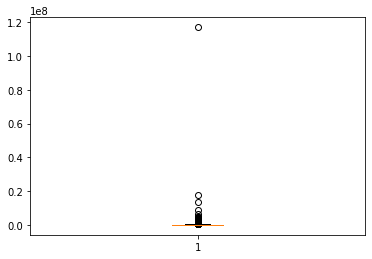

AMT_CREDIT


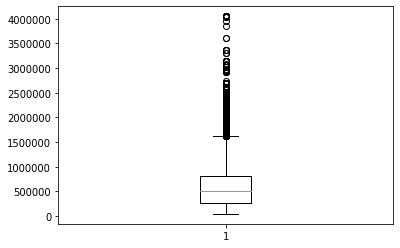

AMT_ANNUITY


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


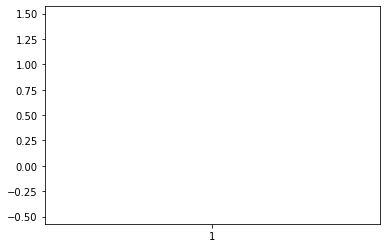

AMT_GOODS_PRICE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


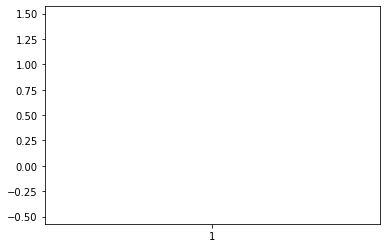

REGION_POPULATION_RELATIVE


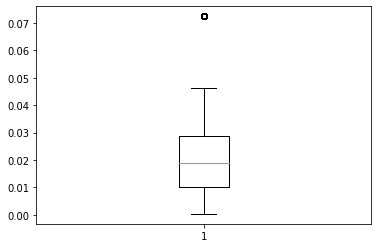

DAYS_REGISTRATION


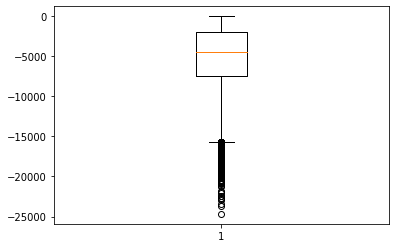

OWN_CAR_AGE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


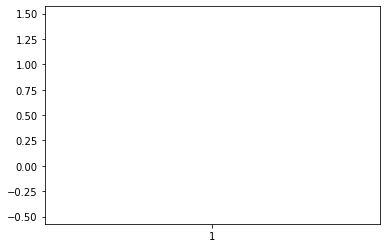

CNT_FAM_MEMBERS


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


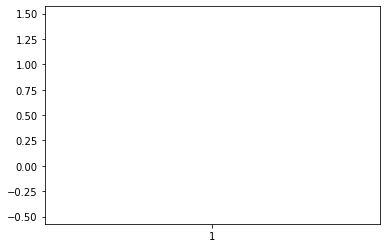

EXT_SOURCE_1


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


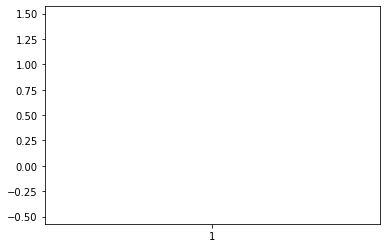

EXT_SOURCE_2


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


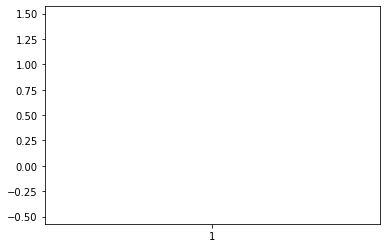

EXT_SOURCE_3


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


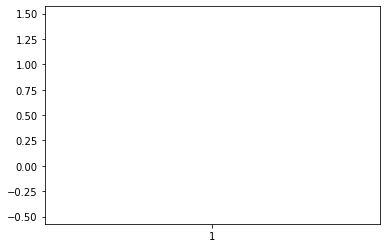

APARTMENTS_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


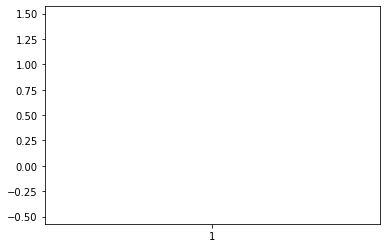

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


BASEMENTAREA_AVG


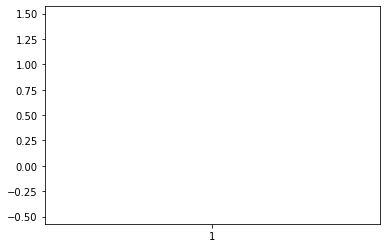

YEARS_BEGINEXPLUATATION_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


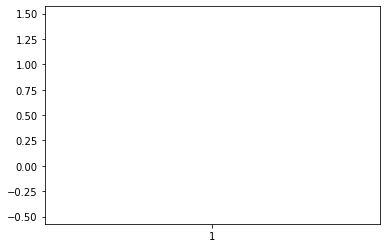

YEARS_BUILD_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


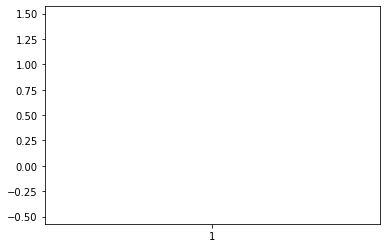

COMMONAREA_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


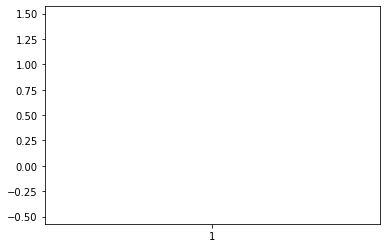

ELEVATORS_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


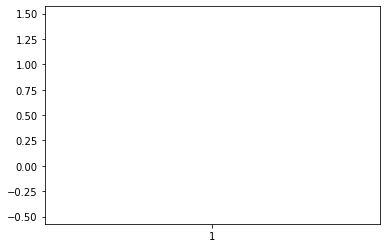

ENTRANCES_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


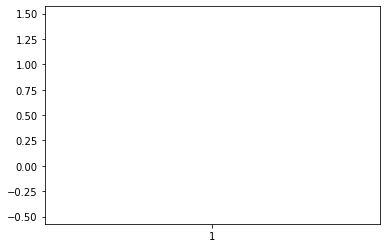

FLOORSMAX_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


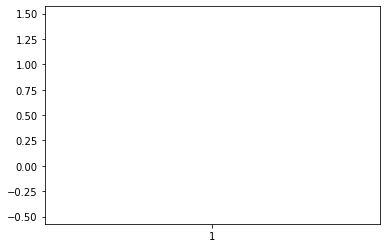

FLOORSMIN_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


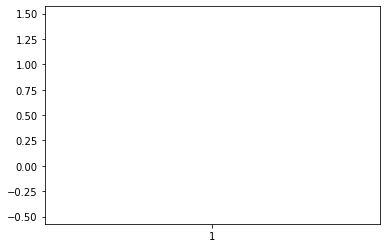

LANDAREA_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


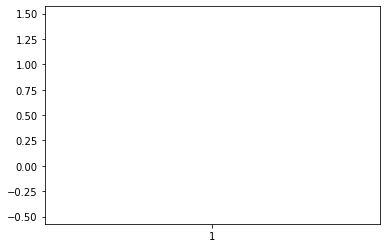

LIVINGAPARTMENTS_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


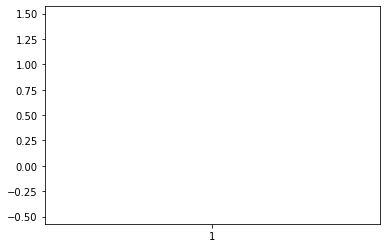

LIVINGAREA_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


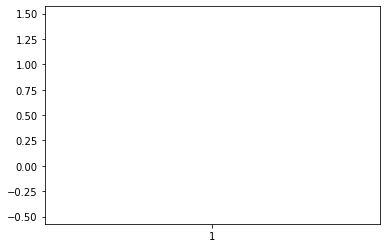

NONLIVINGAPARTMENTS_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


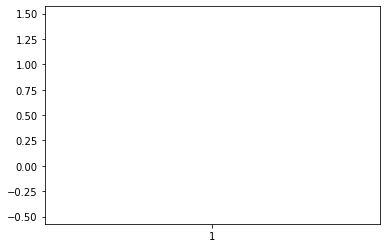

NONLIVINGAREA_AVG


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


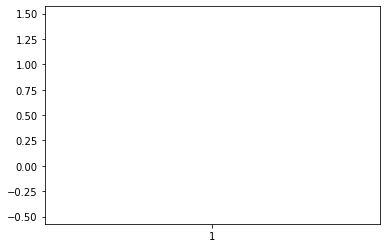

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


APARTMENTS_MODE


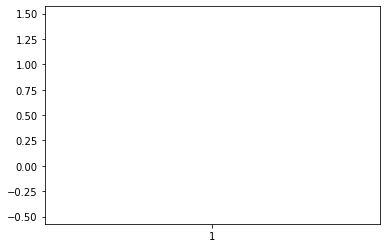

BASEMENTAREA_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


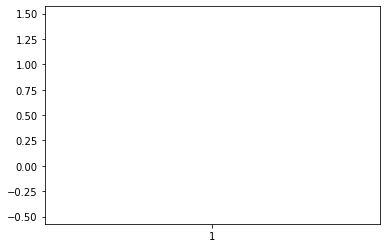

YEARS_BEGINEXPLUATATION_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


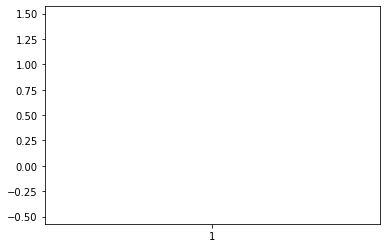

YEARS_BUILD_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


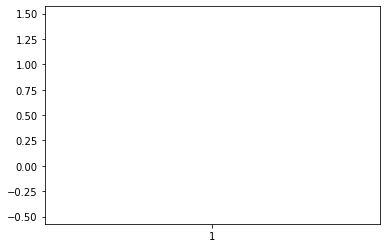

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


COMMONAREA_MODE


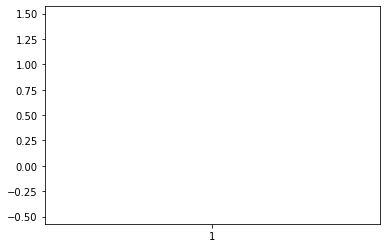

ELEVATORS_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


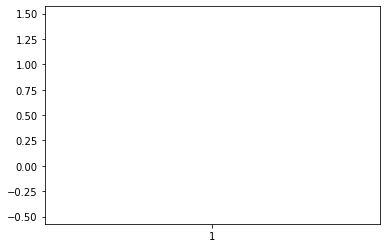

ENTRANCES_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


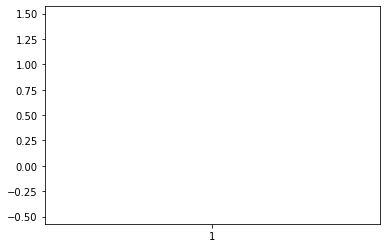

FLOORSMAX_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


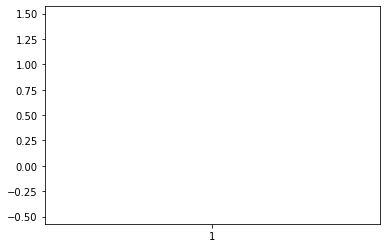

FLOORSMIN_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


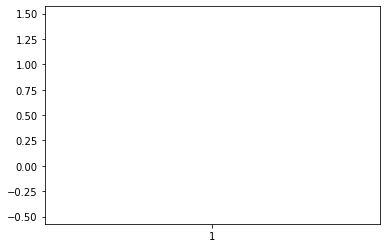

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


LANDAREA_MODE


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


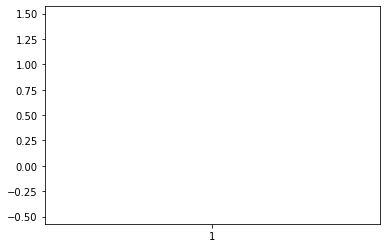

LIVINGAPARTMENTS_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


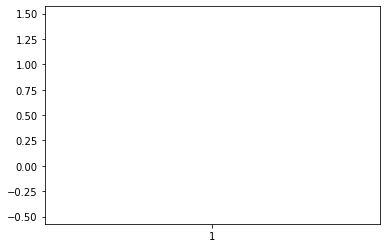

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


LIVINGAREA_MODE


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


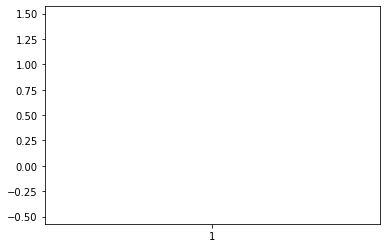

NONLIVINGAPARTMENTS_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


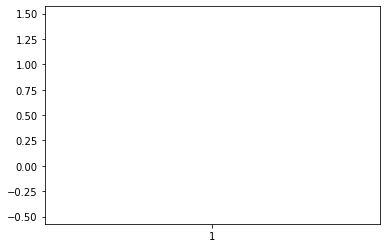

NONLIVINGAREA_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


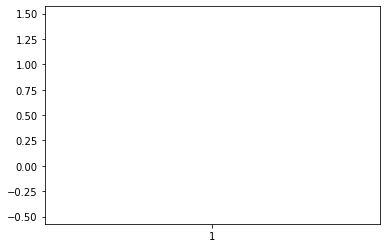

APARTMENTS_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


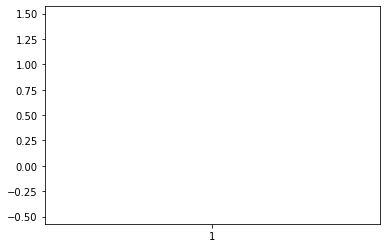

BASEMENTAREA_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


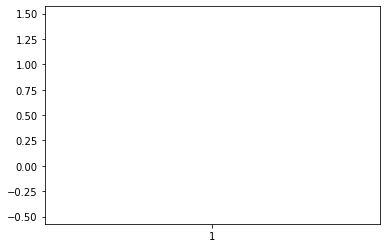

YEARS_BEGINEXPLUATATION_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


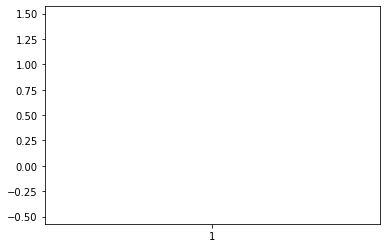

YEARS_BUILD_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


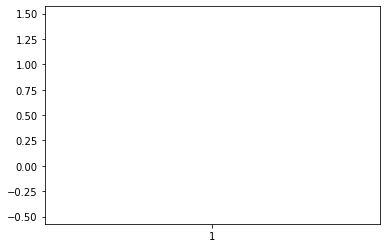

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


COMMONAREA_MEDI


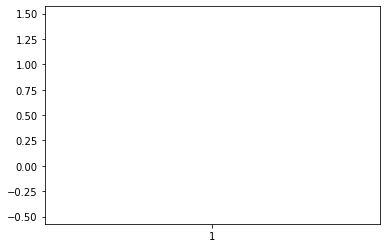

ELEVATORS_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


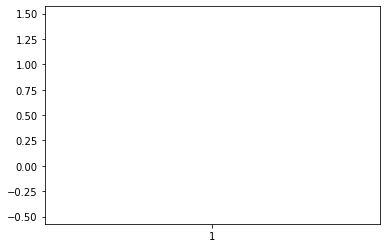

ENTRANCES_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


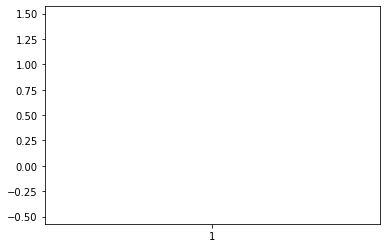

FLOORSMAX_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


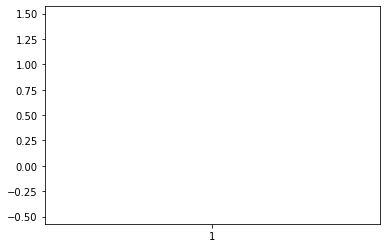

FLOORSMIN_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


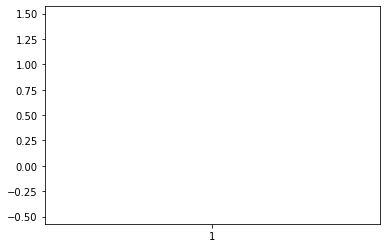

LANDAREA_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


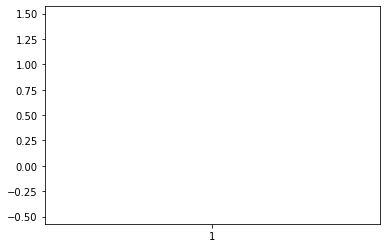

LIVINGAPARTMENTS_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


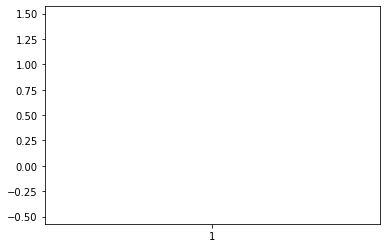

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


LIVINGAREA_MEDI


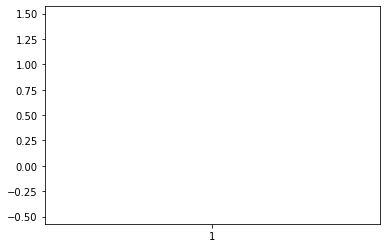

NONLIVINGAPARTMENTS_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


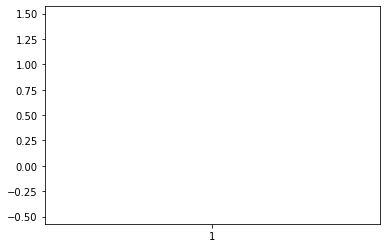

NONLIVINGAREA_MEDI


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


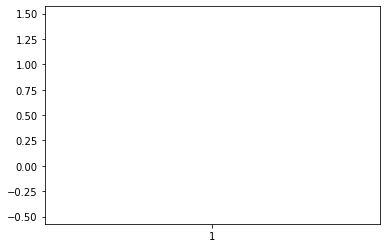

TOTALAREA_MODE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


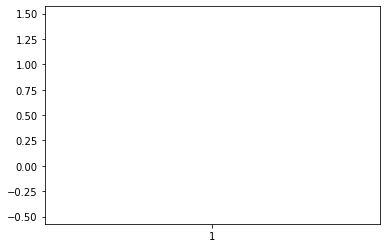

OBS_30_CNT_SOCIAL_CIRCLE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


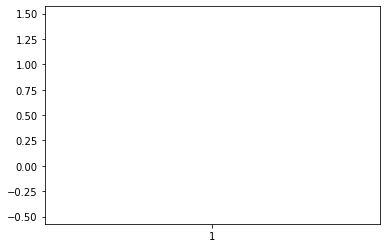

DEF_30_CNT_SOCIAL_CIRCLE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


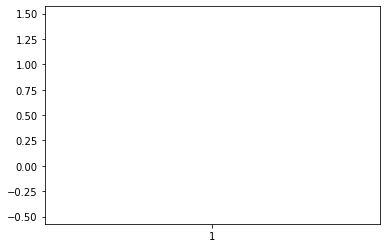

OBS_60_CNT_SOCIAL_CIRCLE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


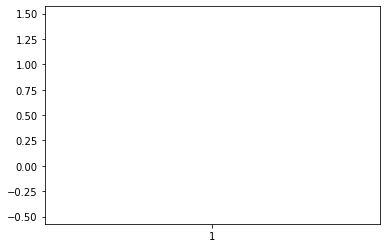

DEF_60_CNT_SOCIAL_CIRCLE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


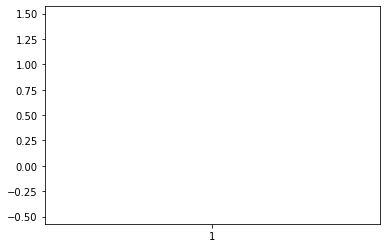

DAYS_LAST_PHONE_CHANGE


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


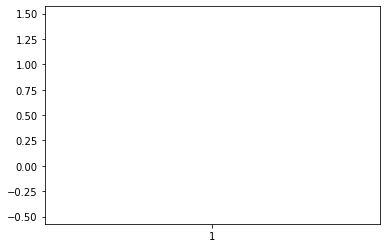

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


AMT_REQ_CREDIT_BUREAU_HOUR


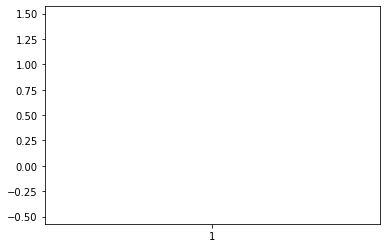

AMT_REQ_CREDIT_BUREAU_DAY


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


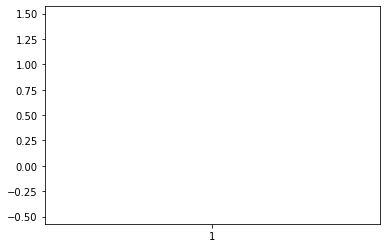

AMT_REQ_CREDIT_BUREAU_WEEK


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


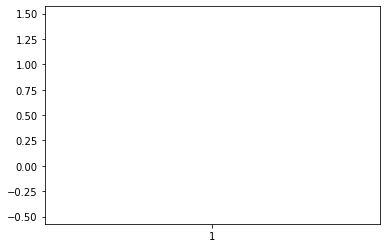

AMT_REQ_CREDIT_BUREAU_MON


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


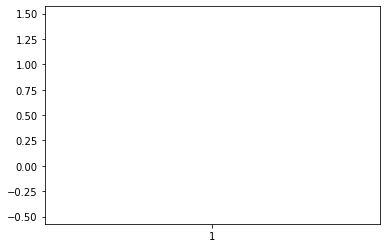

AMT_REQ_CREDIT_BUREAU_QRT


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


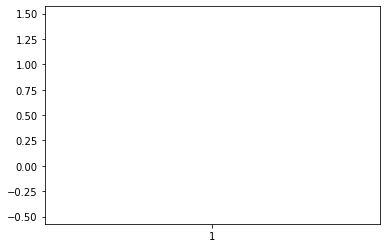

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


AMT_REQ_CREDIT_BUREAU_YEAR


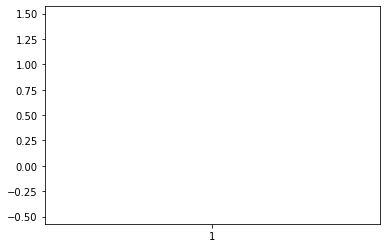

In [4]:
# 先篩選數值型的欄位

"""
YOUR CODE HERE, fill correct data types (for example str, float, int, ...)
"""

#AMT_CREDIT:借貸信用額度過低或過高可能就有問題
#CNT_FAM_MEMBERS:家人數目過高可能有問題
#DAYS_LAST_PHONE_CHANGE:若前幾天才換手機的可能有問題

dtype_select = [np.dtype('float64')] # np.dtype('int64'),
numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])

# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])
print(numeric_columns)
print("Numbers of remain columns %f \n" % len(numeric_columns))


#檢視這些欄位的數值範圍
for i,col in enumerate(numeric_columns):
    """
    Your CODE HERE, make the box plot
    """ 
    print(col)
    plt.boxplot(app_train[col], sym ="o")#whis = 1.5
    color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Red')
    # boxes表示箱體，whisker表示觸鬚線
    # medians表示中位數，caps表示最大與最小值界限
    plt.show()


In [5]:
for i,col in enumerate(numeric_columns):
    print(app_train[col].value_counts())

135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
101119.5        1
79425.0         1
101128.5        1
202275.0        1
262174.5        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64
450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
827100.0        1
413442.0        1
1652458.5       1
825853.5        1
2097058.5       1
Name: AMT_CREDIT, Length: 5603, dtype: int64
9000.0     6385
13500.0    5514
6750.0     2279
10125.0    2035
37800.0    1602
           ... 
15210.0       1
50265.0       1
73012.5       1
40558.5       1
4437.0        1
Name: AMT_ANNUITY, Length: 13672, dtype: int64
450000.0    26022
225000.0    25282
675000.0    24962
900000.0    15416
270000.0    11428
            ...  
705892.5        1
442062.0        1
353641.5        1
353749.5        1
738945.0        1
Name: AMT_GOODS_PRICE, Length: 1002, dtype: int64
0.035792    16408
0.046220    13442
0

Name: APARTMENTS_MEDI, Length: 1148, dtype: int64
0.0000    14991
0.0818      271
0.1091      266
0.0545      265
0.0727      248
          ...  
0.2983        1
0.4633        1
0.4724        1
0.9125        1
0.2919        1
Name: BASEMENTAREA_MEDI, Length: 3772, dtype: int64
0.9871    4314
0.9861    4247
0.9856    4199
0.9866    4138
0.9801    4115
          ... 
0.8967       1
0.9101       1
0.4873       1
0.9091       1
0.8818       1
Name: YEARS_BEGINEXPLUATATION_MEDI, Length: 245, dtype: int64
0.8256    2994
0.8189    2883
0.8054    2842
0.7316    2799
0.8121    2784
          ... 
0.3828       2
0.2083       2
0.0339       1
0.0406       1
0.0071       1
Name: YEARS_BUILD_MEDI, Length: 151, dtype: int64
0.0000    8691
0.0079     581
0.0080     486
0.0078     481
0.0014     377
          ... 
0.7109       1
0.2660       1
0.7736       1
0.8911       1
0.1534       1
Name: COMMONAREA_MEDI, Length: 3202, dtype: int64
0.00    87026
0.08    10832
0.16     9278
0.24     6392
0.12     

In [6]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE

In [7]:
np.cumsum(app_train['AMT_INCOME_TOTAL'])

0         2.025000e+05
1         4.725000e+05
2         5.400000e+05
3         6.750000e+05
4         7.965000e+05
              ...     
307506    5.190666e+10
307507    5.190674e+10
307508    5.190689e+10
307509    5.190706e+10
307510    5.190722e+10
Name: AMT_INCOME_TOTAL, Length: 307511, dtype: float64

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


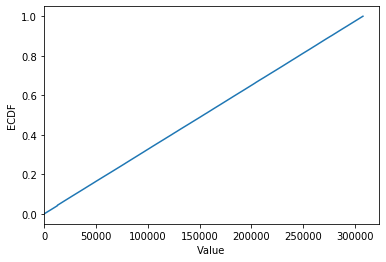

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


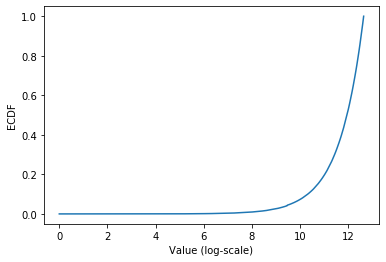

In [8]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
YOUR CODE HERE
"""
cdf = np.cumsum(app_train['AMT_INCOME_TOTAL'])


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')

plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


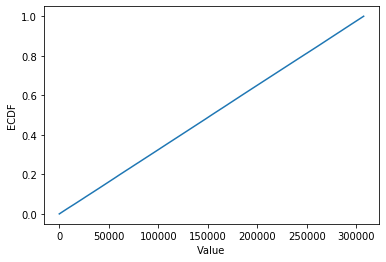

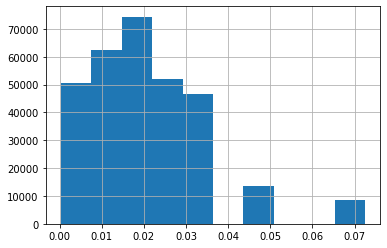

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [9]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here
"""
cdf = np.cumsum(app_train['REGION_POPULATION_RELATIVE'])


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


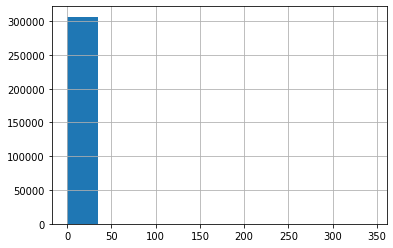

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [10]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
"""
Your Code Here

cdf = 


plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()
"""
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

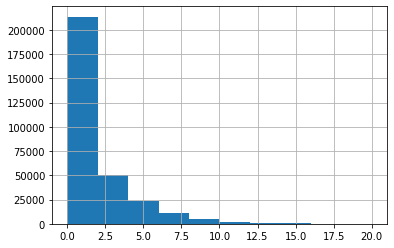

In [11]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製
"""
Your Code Here

print(app_train.loc[20::, loc_b])
app_train.loc[20::, loc_b].hist()
"""
loc_a = app_train['OBS_60_CNT_SOCIAL_CIRCLE']<=20
loc_b ='OBS_60_CNT_SOCIAL_CIRCLE'
app_train.loc[loc_a, loc_b].hist()
plt.show()

In [12]:
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
344.0         1
47.0          1
26.0          1
30.0          1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64